# EBLR

In [1]:
from lineartree import LinearBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import pandas as pd
from joblib import dump
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/superconductivity.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/superconductivity.parquet')

y_train = train.critical_temp
X_train = train.drop(columns=['critical_temp'])

y_validation = validation.critical_temp
X_validation = validation.drop(columns=['critical_temp'])

In [5]:
scaler = StandardScaler().fit(X_train)

In [6]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [7]:
max_depth = [1, 2, 3]
n_est = [1, 2, 3, 4, 5, 7, 9]
base_est =  [LinearRegression(), Ridge(), Lasso(), ElasticNet(l1_ratio=0.25), ElasticNet(l1_ratio=0.5), ElasticNet(l1_ratio=0.75)]
loss = ['linear', 'square']

In [8]:
models_list = []
for n in n_est:
    for i in max_depth:
        for est in base_est:
            for l in loss:
                models_list.append(LinearBoostRegressor(base_estimator=est, n_estimators=n, max_depth=i, loss=l))

In [9]:
names_list = []
for n in n_est:
    for depth in max_depth:
        for est in base_est:
            for l in loss:
                if isinstance(est, LinearRegression):
                    name = f'EBLR_{depth}_{n}_{l}'
                elif isinstance(est, Ridge):
                    name = f'EBLR_{depth}_{n}_{l}_l2'
                elif isinstance(est, Lasso):
                    name = f'EBLR_{depth}_{n}_{l}_l1'
                elif isinstance(est, ElasticNet):
                    name = f'EBLR_{depth}_{n}_{l}_en_{est.l1_ratio}'
                else:
                    raise ValueError('Unknown base estimator type')

                names_list.append(name)

In [104]:
metrics = regression(models_list, names_list, '../../../data/metrics/superconductivity/eblr.csv', X_train_scaled, y_train, X_validation_scaled, y_validation, metrics={})
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
EBLR_1_1_linear,0.418835,15.651516,54.438621,247.816913
EBLR_1_1_square,0.346075,16.286579,52.616275,223.065237
EBLR_1_1_linear_l2,0.211048,16.009496,48.926377,205.608467
EBLR_1_1_square_l2,0.214477,15.970235,50.878180,218.581281
EBLR_1_1_linear_l1,0.589617,17.949506,33.373291,85.928741
...,...,...,...,...
EBLR_2_15_linear_en_0.25,22.814173,18.674180,31.762745,70.089104
EBLR_2_15_linear_en_0.5,17.418525,18.622542,31.979932,71.726998
EBLR_1_15_linear_en_0.5,15.776640,17.595561,29.156177,65.701889
EBLR_1_15_linear_en_0.75,9.565164,17.383704,29.323386,68.683190


In [105]:
metrics.sort_values(by='Validation_RMSE').head(15)

,Run_Time,Train_RMSE,Validation_RMSE,delta%
EBLR_1_7_linear_l1,2.377853,16.974706,28.566242,68.287114
EBLR_1_11_linear_l1,3.784542,16.974706,28.566242,68.287114
EBLR_1_15_linear_l1,4.801371,16.974706,28.566242,68.287114
EBLR_1_13_linear_l1,4.406460,16.974706,28.566242,68.287114
EBLR_1_9_linear_l1,3.156989,16.974706,28.566242,68.287114
EBLR_1_5_linear_l1,1.793978,17.120140,29.135542,70.182856
EBLR_1_15_linear_en_0.5,15.776640,17.595561,29.156177,65.701889
EBLR_2_15_linear,6.387766,13.472004,29.185250,116.636298
EBLR_1_15_linear_en_0.75,9.565164,17.383704,29.323386,68.683190
EBLR_2_9_linear_l1,3.975906,16.862608,29.386262,74.268791


We select **EBLR_1_7_linear_l1**

In [13]:
test =  pd.read_parquet('../../../data/model_input/test_sets/superconductivity.parquet')

In [14]:
y_test = test.critical_temp
X_test = test.drop(columns=['critical_temp'])

In [15]:
retrain = pd.concat([train, validation])

In [16]:
y_retrain = retrain.critical_temp
X_retrain = retrain.drop(columns=['critical_temp'])

In [17]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [18]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [115]:
model = LinearBoostRegressor(base_estimator=Lasso(), max_depth=1, n_estimators=7).fit(X_retrain_scaled, y_retrain)

In [116]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 17.5645


In [117]:
dump(model, 'best_eblr.joblib')

['best_eblr.joblib']

In [118]:
with open('../../../data/metrics/superconductivity/final_RMSE.txt', 'a') as f:
    f.write('\nEBLR, '+ str(rmse))

In [119]:
print(f'Initial number of features: {X_retrain.shape[1]}\nFinal number of features: {model.transform(X_retrain_scaled).shape[1]}')

Initial number of features: 167
Final number of features: 174


In [120]:
error_trees = model._trees

#### New Feature 1

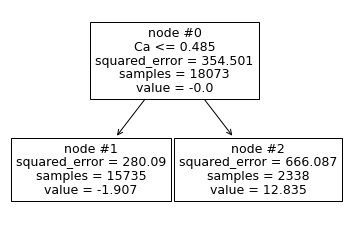

In [121]:
plot_tree(error_trees[0], node_ids=True, feature_names=X_retrain.columns);

In [122]:
pred = np.abs(error_trees[0].predict(X_retrain_scaled))
worst_leaf = np.argmax(pred)
error_path = error_trees[0].decision_path(X_retrain_scaled[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

In [123]:
path1 = []
for i in indexes[:-1]:
    path1.append(str(X_retrain.columns[error_trees[0].tree_.feature[i]])+' <= '+str(error_trees[0].tree_.threshold[i]))
path1.append('leaf value: '+str(model._leaves[0]))

path1

['Ca <= 0.4849570095539093', 'leaf value: 12.834656760164352']

This first new feature will assign 1 to samples not verifying $Ca \leq 0.4849570095539093$ and $0$ to the rest.

In [124]:
pred_tree = np.abs(error_trees[0].predict(X_retrain_scaled.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[0]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_retrain_scaled, pred_tree], axis=1)

#### New Feature 2

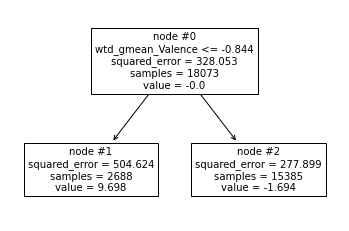

In [125]:
plot_tree(error_trees[1], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1']);

In [126]:
pred = np.abs(error_trees[1].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[1].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path2 = []
for i in indexes[:-1]:
    path2.append(str(list(list(X_retrain.columns)+['New_Feature_1'])[error_trees[1].tree_.feature[i]])+' <= '+str(error_trees[1].tree_.threshold[i]))
path2.append('leaf value: '+str(model._leaves[1]))

path2

['wtd_gmean_Valence <= -0.8435302972793579', 'leaf value: 9.698196215891835']

This new variable assigns 1 to samples that verify $wtd\_gmean\_Valence \leq -0.8435302972793579$, and 0 to the rest.

In [127]:
pred_tree = np.abs(error_trees[1].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[1]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 3

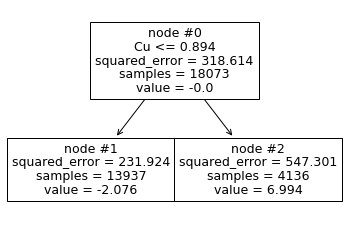

In [128]:
plot_tree(error_trees[2], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2']);

In [129]:
pred = np.abs(error_trees[2].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[2].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path3 = []
for i in indexes[:-1]:
    path3.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2'])[error_trees[2].tree_.feature[i]])+' <= '+str(error_trees[2].tree_.threshold[i]))
path3.append('leaf value: '+str(model._leaves[2]))

path3

['Cu <= 0.8943641781806946', 'leaf value: 6.993869009246676']

Samples that give $False$ to that condition are assigned a 1 on this variable 

In [130]:
pred_tree = np.abs(error_trees[2].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[2]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 4

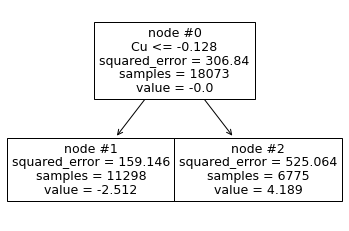

In [131]:
plot_tree(error_trees[3], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3']);

In [132]:
pred = np.abs(error_trees[3].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[3].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path4 = []
for i in indexes[:-1]:
    path4.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3'])[error_trees[3].tree_.feature[i]])+' <= '+str(error_trees[3].tree_.threshold[i]))
path4.append('leaf value: '+str(model._leaves[3]))

path4

['Cu <= -0.12832575291395187', 'leaf value: 4.188959323275503']

If $Cu \leq -0.12832575291395187$ is $False$ then a 1 is assigned on this variable

In [133]:
pred_tree = np.abs(error_trees[3].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[3]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 5

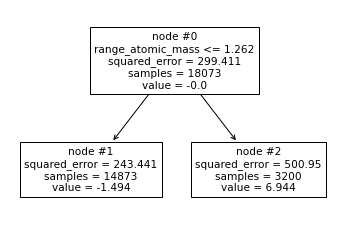

In [134]:
plot_tree(error_trees[4], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4']);

In [135]:
pred = np.abs(error_trees[4].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[4].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path5 = []
for i in indexes[:-1]:
    path5.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4'])[error_trees[4].tree_.feature[i]])+' <= '+str(error_trees[4].tree_.threshold[i]))
path5.append('leaf value: '+str(model._leaves[4]))

path5

['range_atomic_mass <= 1.2623003721237183', 'leaf value: 6.944220741023532']

Samples with $range\_atomic\_mass > 1.2623003721237183$ are given a 1 in this feature.

In [136]:
pred_tree = np.abs(error_trees[4].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[4]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 6

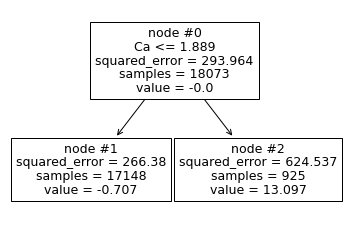

In [137]:
plot_tree(error_trees[5], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4, New_Feature_5']);

In [138]:
pred = np.abs(error_trees[5].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[5].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path6 = []
for i in indexes[:-1]:
    path6.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4, New_Feature_5'])[error_trees[5].tree_.feature[i]])+' <= '+str(error_trees[5].tree_.threshold[i]))
path6.append('leaf value: '+str(model._leaves[5]))

path6

['Ca <= 1.888571321964264', 'leaf value: 13.097289809190901']

If a sample has $Ca > 1.888571321964264$, then its value for this feature will be 1.

In [139]:
pred_tree = np.abs(error_trees[5].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[5]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 7

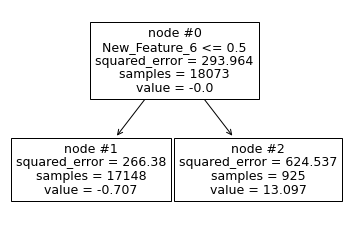

In [157]:
plot_tree(error_trees[6], node_ids=True, feature_names=list(list(X_retrain.columns)+['New_Feature_1']+['New_Feature_2']+['New_Feature_3']+['New_Feature_4']+['New_Feature_5']+['New_Feature_6']));

In [159]:
pred = np.abs(error_trees[6].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[6].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path7 = []
for i in indexes[:-1]:
    path7.append(str(list(list(X_retrain.columns)+['New_Feature_1']+['New_Feature_2']+['New_Feature_3']+['New_Feature_4']+['New_Feature_5']+['New_Feature_6'])[error_trees[6].tree_.feature[i]])+' <= '+str(error_trees[6].tree_.threshold[i]))
path7.append('leaf value: '+str(model._leaves[6]))

path7

['New_Feature_6 <= 0.5', 'leaf value: 13.097289809190901']

This new variable generates a repeated column. Let's see the final linear model:

In [168]:
top_threshold = 0
top_coefficients = [coef for coef in model.base_estimator_.coef_.ravel() if abs(coef) > top_threshold]
top_features = [name for name, coef in zip(X_retrain.columns, model.base_estimator_.coef_.ravel()) if abs(coef) > top_threshold]

In [169]:
labels = [' ' if feature not in top_features else feature for feature in X_retrain.columns]+['New_Feature_1']+['New_Feature_2']+['New_Feature_3']+['New_Feature_4']+['New_Feature_5']+['New_Feature_6']+['New_Feature_7']

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_8592/676169912.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90, ha='right')


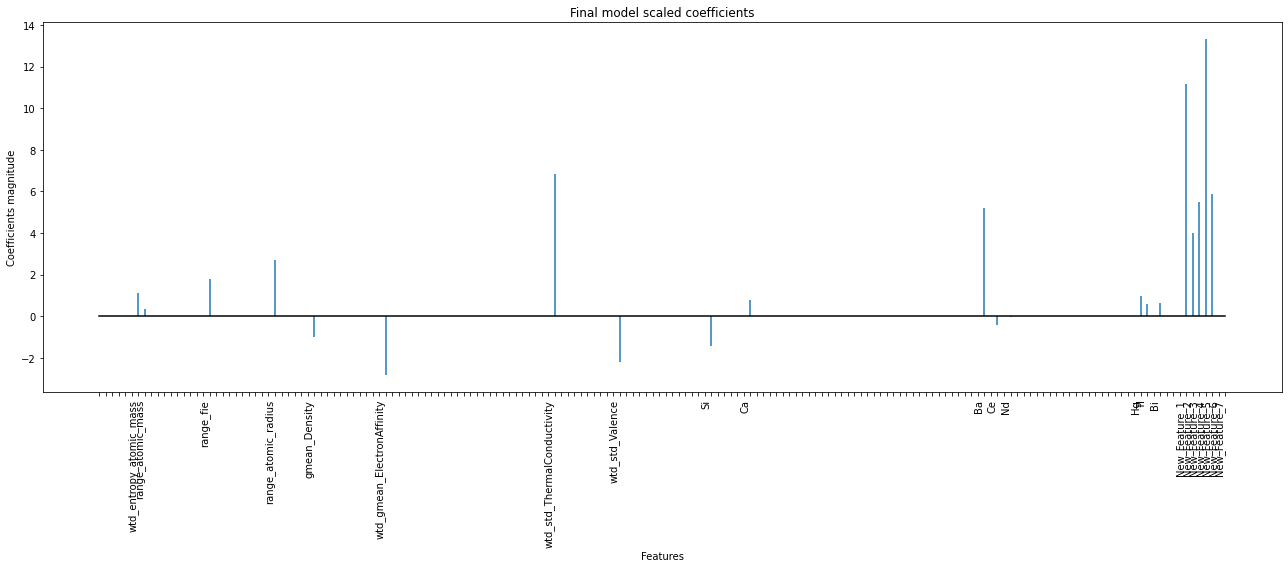

In [170]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.stem(list(list(X_retrain.columns)+['New_Feature_1']+['New_Feature_2']+['New_Feature_3']+['New_Feature_4']+['New_Feature_5']+['New_Feature_6']+['New_Feature_7']), model.base_estimator_.coef_.ravel(), markerfmt=' ', basefmt='k-')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Final model scaled coefficients')
ax.set_xticklabels(labels, rotation=90, ha='right')
plt.tight_layout()
plt.show()

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_8592/1387393881.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],


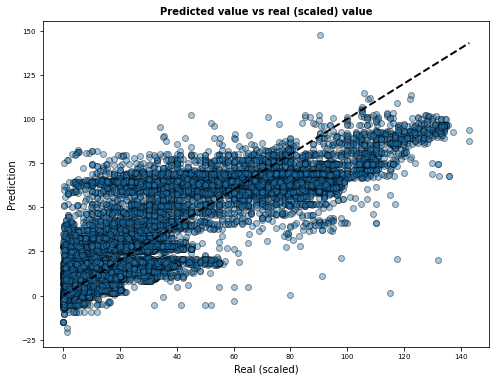

In [171]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real (scaled) value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real (scaled)')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)